_Behavior of the Maximum Likelihood in Quantum State Tomography_ - Supplemental Notebook II
================================

Travis Scholten and Robin Blume-Kohout, _Sandia National Labs_ and the _Center for Quantum Information and Control, University of New Mexico_

The purpose of this notebook is to explain the derivation of our solution for $q/\epsilon$, Equation ??, in our paper, available on the [arXiv](https://arxiv.org/abs/1609.04385).

This notebook requires installing ``sympy``, ``matplotlib``, ``numpy``, ``pandas``, ``sympy``, and ``seaborn``. If you don't want to install seaborn, then that's OK - the color schemes and formatting will just look a little bit different!

If you've arrived at this notebook by cloning the [GitHub repository for this paper](https://github.com/Travis-S/2016_MaxLik_Tomography), the data files referenced are located in the `Data` directory.

In the main text of the paper, we have to solve the following equation

$$\frac{rq}{\epsilon} = \frac{4N^{1/4}}{15\pi}\left(2\sqrt{N} - \frac{q}{\epsilon}\right)^{5/2}$$

for $q$, where $N  = d-r$. As we mentioned, this is a quintic polynomial in $q/\epsilon$, meaning that an algebraic solution is [generally impossible](https://en.wikipedia.org/wiki/Abel%E2%80%93Ruffini_theorem). Here, we instead pursue an _approximate_ solution.

Let's first start by defining $z \equiv q/\epsilon$, and then squaring both sides:

$$r^{2}z^{2} = \left(\frac{4}{15\pi}\right)^{2}\sqrt{N}\left(2\sqrt{N} - z\right)^{5}$$

The next thing to do is factor out the $2 \sqrt{N}$:

$$r^{2}z^{2} = 32\left(\frac{4}{15\pi}\right)^{2}N^{3}\left(1 - \frac{z}{2\sqrt{N}}\right)^{5}$$

Defining $y  = z/2\sqrt{N}$ and factoring some things puts the equation in a pretty nice form:

$$y^{2} = 32\left(\frac{2N}{15\pi r}\right)^{2}\left(1 - y\right)^{5}$$

For convenience, let's define $A =32\left(\frac{2N}{15\pi r}\right)^{2}$:

$$y^{2} = A\left(1 - y\right)^{5} \implies y^{2}-A*\left(1 - y\right)^{5} = 0$$

Our task is to now solve this equation for $y$. First though, let's develop a tool to help us check whatever approximation we come up with. In the ``Data`` directory, the file ``avg_decrement.csv`` provides numerically-averaged values for $z$. We will compare our approximation to those numerics.

In [5]:
#Preliminary code imports
from __future__ import division
import numpy as np
import pandas as pd
import sympy

try:
    import seaborn
except Exception ,err:
    print('seaborn not installed')
    pass

import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2


from scipy import optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To do the comparison, we'll make plots of the column ``avg_dec`` in the file against the value predicted by the theory, as well as plots showing how the theory performs as a function of $d,r$. We load this file into a ``pandas`` dataframe.

In [8]:
df = pd.read_csv('Data/avg_decrement.csv')
df.head()

,avg_dec,dim,numTrials,rankTrue
0,2.707205,10.0,100000.0,1.0
1,1.855859,10.0,100000.0,2.0
2,1.321407,10.0,100000.0,3.0
3,0.940755,10.0,100000.0,4.0
4,0.653351,10.0,100000.0,5.0


In [22]:
def theory_comp_plot(theory):
    r'''
    Makes a plot comparing a theory for the decrement z to
    numerics.
    
    Inputs
    -----
    theory: A function f(d, r) which takes as input a Hilbert space
            dimension d, and a rank r <= d, and returns z
    
    Returns
    ------
    None. Makes a plot
    '''
    
    #Copy the dataframe
    T = df.copy()
    
    T.loc[:, 'theory'] = T.apply(lambda r: theory(r['dim'], r['rankTrue']), axis=1)
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 2, 1)

    X = T['avg_dec'].values
    Y = T['theory'].values

    ax.plot(X, Y, ls='', marker='o')
    ax.plot(X, X, ls='-')
    
    ax.set_xlabel('Numerical Average ("True Value")', fontsize=20)
    ax.set_ylabel('Predicted Value', fontsize=20)
    ax.set_title('Evaluating Theory for $z$', fontsize=20)
    for s in ['x', 'y'] : ax.tick_params(axis=s, labelsize=15)
    #FIX THIS!!!!
    ranks = T['rankTrue'].unique()
    colors = seaborn.color_palette('husl', n_colors = len(ranks))
    
    ax = fig.add_subplot(1, 2, 2)
    counter = 0
    for r in ranks:
        temp = T[T['rankTrue'] == r].sort_values(by=['dim'])
        X = temp['dim'].values
        Y = temp['avg_dec'].values

        ax.plot(X, Y, ls='', marker='o', clip_on=False, color=colors[counter], label=r'$r={0}$'.format(int(r)))

        Z = temp['theory'].values
        
        ax.plot(X, Z, ls='-', marker='', clip_on=False, color=colors[counter])

        counter += 1

    ax.legend(loc=0)
    
    ax.set_xlabel('Hilbert Space Dimension $d$', fontsize=20)
    ax.set_ylabel('$z$', fontsize=20)
    ax.set_title('Comparing Theory and Numerics\nas a Function of $d,r$', fontsize=20)
    for s in ['x', 'y'] : ax.tick_params(axis=s, labelsize=15)

Our first "theory" for $z$ is simply to numerically solve the equation above.

In [18]:
#Define two helper functions
def a(d ,r):
    r'''Calculates the quantity A defined previously'''
    return 32 * (2 * (d - r) / (15 * np.pi * r))**2

def f(x, A):
    r'''The exact f(x) above'''
    return x ** 2 - A*(1-x)**5
    
def numerical_theory(d, r):
    
    A = a(d, r)
    
    def g(x):
        return f(x, A)
    
    N = d - r
    
    #An exact numerical root
    return 2*np.sqrt(N) * optimize.newton(g, 0)

With this theory in hand, we evaluate its performance:

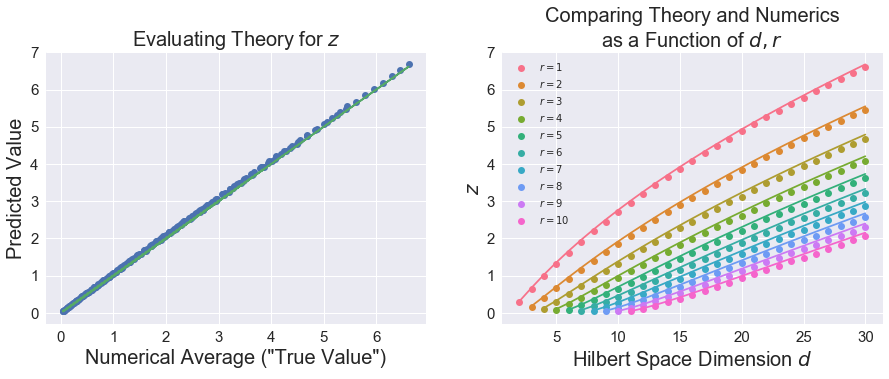

In [23]:
theory_comp_plot(numerical_theory)

NOTE: In the right-hand plot, the dots indicate the numerical average ("true value"), while the solid lines will indicate the value predicted by whatever theory we pass to ``theory_comp_plot``.

The aggrement is great! The problem we face is that we had to use a numerical root-finding tool. To make progress on an analytical solution, observe that we may write the defining equation for $y$ as

$$y^{2/5} + A^{1/5}(y-1) = 0$$

As mentioned in the main text, with high probability, $z \sim 2 \sqrt{N}$, meaning $y \sim 1$. Using this fact, we now compute the Taylor series of $y^{2/5}$ about $y_{0} = 1$.

In [24]:
sympy.init_printing(True)

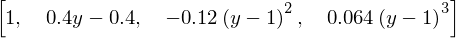

In [26]:
#Declare a sympy symbol
y = sympy.symbols('y')

#"Manually" compute the Taylor series
[sympy.diff(y**(2/5), y, n).subs({y:1})/(sympy.factorial(n))*(y-1)**n for n in range(0, 4)]

The series is


$$y^{2/5} \approx 1 + .4(y-1)-.12(y-1)^{2} + \mathcal{O}((y-1)^{3})$$

Let's see how this Taylor series performs.

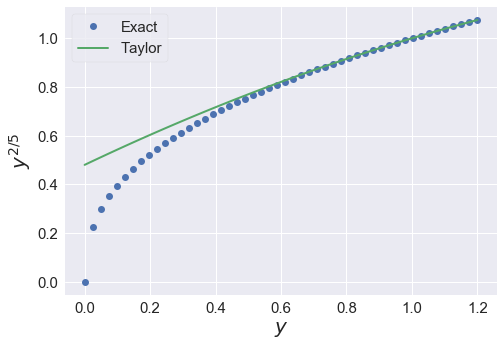

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.linspace(0, 1.2)
Z = 1 + .4*(X-1) - .12 * (X-1)**2
ax.plot(X, X**(2/5), ls='', marker='o', label='Exact')
ax.plot(X, Z, lw=2, label='Taylor')

ax.legend(loc=0, frameon=True, fancybox=True,fontsize=15)
for s in ['x', 'y'] : ax.tick_params(axis=s, labelsize=15)
        
ax.set_xlabel(r'$y$', fontsize=20)
ax.set_ylabel(r'$y^{2/5}$', fontsize=20)

In the vicinity of $y=1$, the agreement is essentially perfect. However, as $y \rightarrow 0$ (which will occur as $r \rightarrow d$), we start to see discrepancies.

Replacing $y^{2/5}$ by its Taylor series, we now end up with a quadratic equation in $y$:

$$1 + (.4 + A^{1/5})(y-1)-.12(y-1)^{2} = 0$$

Let's check that the roots of this equation agree well with the original numerics.

In [32]:
def taylor_theory(d, r):
    r'''

    
    '''
    A = a(d, r)
    
    #Define the Taylor series
    def f(y, a):
        return 1 + (.4 + a**.2)*(y-1)-.12*(y-1)**2
    def g(y):
        return f(y, A)
    
    N = d - r
    #Compute the numerical root
    return 2*np.sqrt(N) * optimize.newton(g, 0)

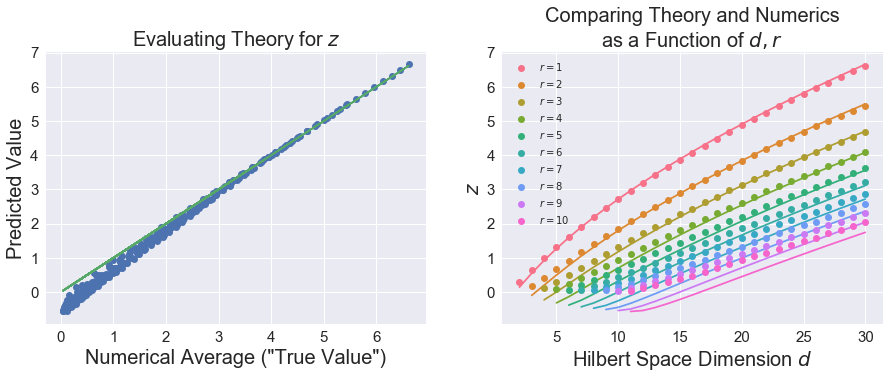

In [33]:
theory_comp_plot(taylor_theory)

As expected, there are some issues, particularly when the true value is close to zero. However, the agreement is otherwise pretty good.

Now that we have a quadratic equation in $y$, we can easily solve it.

In [34]:
A,y = sympy.symbols('A,y')
f = 1 + (.4 + A**.2)*(y-1)-.12*(y-1)**2

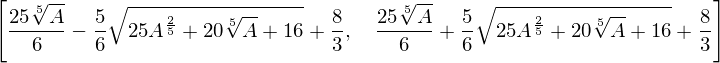

In [35]:
sols = sympy.solve(f, y, rational=True)
sols

Let's plot each of the roots and see which is right.

In [36]:
def taylor_roots(d, r, root='pos'):
    r'''
    
    
    
    '''
    A = a(d, r)  
    N = d - r
    
    t1 = 25*A**(1/5)/6 + 8/3
    
    t2 = 5/6*np.sqrt(25.0*A**(2/5) + 20*A**(1/5) + 16)
    
    if root == 'pos':
        v = t1+t2
    else:
        v = t1 - t2

    return 2*np.sqrt(N)*v

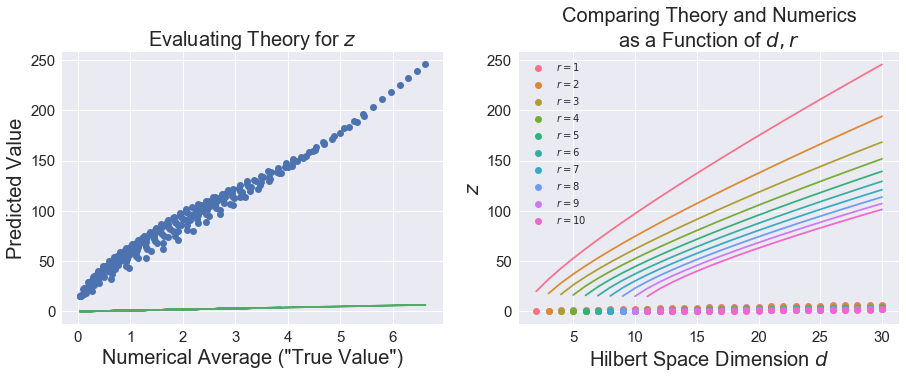

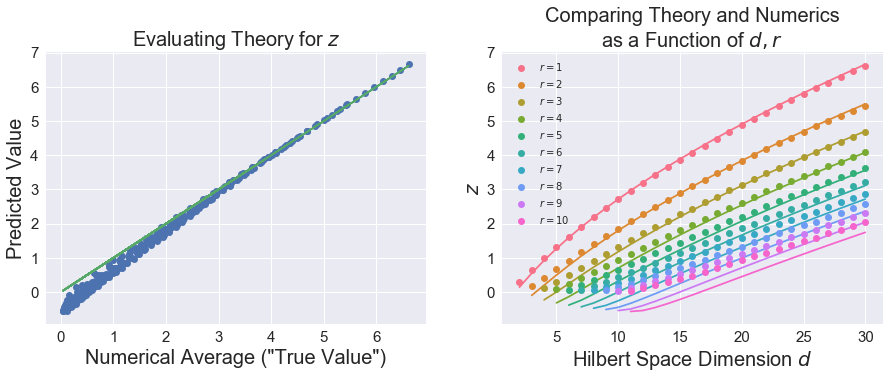

In [37]:
theory_comp_plot(lambda d, r: taylor_roots(d,r)),
theory_comp_plot(lambda d, r: taylor_roots(d,r, root='neg'))

Looks like we should use the negative root.

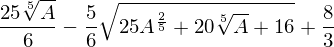

In [38]:
sols[0]

In turn, the decrement $z$ is given by

$$z = 2\sqrt{N}\left(\frac{25A^{1/5}}{6} - \frac{5}{6}\sqrt{25A^{2/5} + 20 A^{1/5} + 16} + \frac{8}{3}\right)$$

with

$$A =32\left(\frac{2N}{15\pi r}\right)^{2}$$

Let's try to take the $N \rightarrow \infty$ limit of this root.

In [47]:
N,r,t = sympy.symbols('N,r,t', real=True, positive=True)

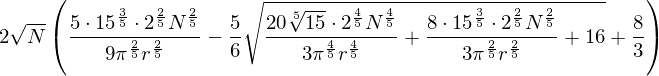

In [40]:
z = 2*sympy.sqrt(N)*sols[0].subs({A:32 * (2 * N / (15 * sympy.pi * r))**2})
z

It turns out that ``sympy`` will throw fits if you try to make it do a series expansion of $z$ with respect to $N$ as $N \rightarrow \infty$. We'll get around this problem by defining $t = r/N$, and taking $t \rightarrow 0$.

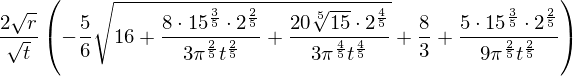

In [43]:
#Substitute r/t for N
z = z.subs({N:r/t})
z

It turns out it will be helpful to define a new quantity, $B = \frac{15 \pi r}{2}$, to do the simplification. In the cell block below, we compute a series expansion in powers of $t$, truncate it to $\mathcal{O}(t^{2})$, re-substitute $t = r/N$, and then substitute $B$ in place of $r$.

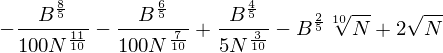

In [52]:
sympy.init_printing()
B = sympy.symbols('B')
sympy.expand(sympy.series(z, t, n=2)).subs({t:r/N}).removeO().subs({r: 2*B/(15 * sympy.pi)})

This is a rather nice expression!
 Re-writing in terms of $r$, we obtain the following expression for $z$:

$$z = 2\sqrt{N} - \left(\frac{15\pi r}{2}\right)^{2/5}N^{1/10} + \frac{1}{5}\left(\frac{15\pi r}{2}\right)^{4/5}N^{-3/10} - \frac{1}{100}\left(\frac{15\pi r}{2}\right)^{6/5}N^{-7/10} - \frac{1}{100}\left(\frac{15\pi r}{2}\right)^{8/5}N^{-11/10}$$

Let's evaluate this expression at several orders, by truncating it at $N^{1/10}$, $N^{-3/10}$, $N^{-7/10}$, and $N^{-11/10}$.

In [63]:
def analytic_taylor_roots(d, r, N_power=1):
    r'''
    
    
    
    '''
    
    assert N_power in [1, 3, 7, 11], 'Please provide a valid value'
    N  = d - r
    
    A = (15 * np .pi * r / 2)
    
    z = 2* np.sqrt(N)
    
    def terms(order=1):
        if order == 1:
            term = - A**(2/5)*N**(1/10)
        elif order == 3:
            term  = terms(order = 1) + 1/5 * (A ** (4/5)) * N**(-3/10)
        elif order == 7:
            term = terms(order = 3)   - 1/100 * A**(6/5)*N**(-7/10) 
        elif order == 11:
            term = terms(order = 7) - 1/100 * A**(8/5)*N**(-11/10)
        return term
    
    z += terms(N_power)
    return z

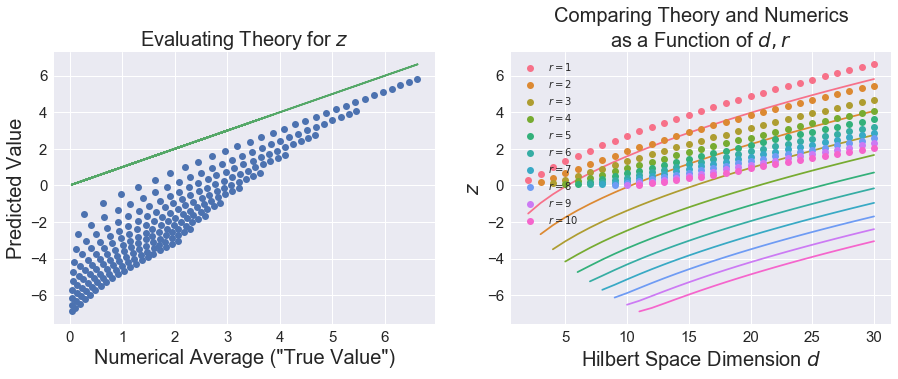

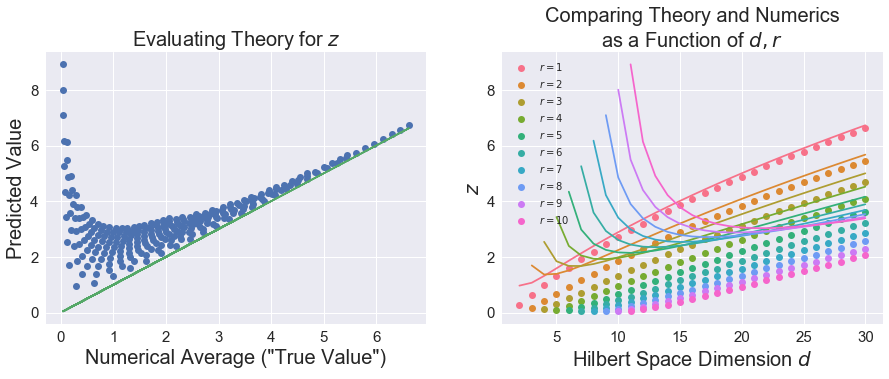

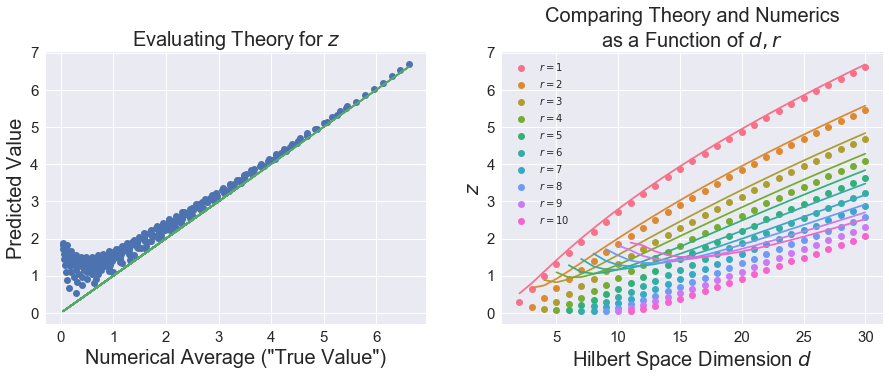

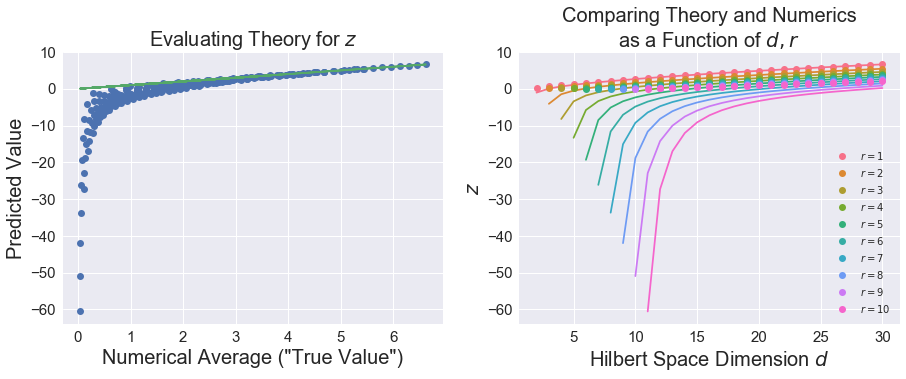

In [64]:
for n in [1, 3, 7, 11]:
    theory_comp_plot(lambda d, r: analytic_taylor_roots(d, r, N_power=n))

Keeping the $N^{1/10}, N^{-3/10}$, and $N^{-7/10}$ terms (3rd row) appears to give the best agreement. Therefore, our approximate expression for $z$ is

$$z \approx 2\sqrt{N} - \left(\frac{15\pi r}{2}\right)^{2/5}N^{1/10} + \frac{1}{5}\left(\frac{15\pi r}{2}\right)^{4/5}N^{-3/10} - \frac{1}{100}\left(\frac{15\pi r}{2}\right)^{6/5}N^{-7/10}$$

Now, we do a little bit of work to re-write this expression in a convenient way. Observe that it's possible to factor out a $2\sqrt{N}$ from the entire expression:

$$z = 2\sqrt{N}\left(1 - \frac{1}{2}\left(\frac{15\pi r}{2}\right)^{2/5}N^{-2/5} + \frac{1}{10}\left(\frac{15\pi r}{2}\right)^{4/5}N^{-4/5} - \frac{1}{200}\left(\frac{15\pi r}{2}\right)^{6/5}N^{-6/5}\right)$$

Defining $x \equiv \left(\frac{15\pi r}{2N}\right)^{2/5}$, our expression for $z$ takes a simple form:


$$\boxed{z = 2\sqrt{N}\left(1 - \frac{1}{2}x +\frac{1}{10}x^{2} - \frac{1}{200}x^{3}\right)}$$